In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#https://scipython.com/blog/quadtrees-2-implementation-in-python/
#https://pydoc.net/openslide-python/1.1.1/openslide/

import numpy as np
import openslide
from probreg import cpd
from probreg import transformation as tf
import cv2
from PIL import Image
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import json

import pickle

In [3]:
## HACK get rid of it
import sys
sys.path.append("..")
from registration_tree import Rect, QuadTree

In [4]:
list(Path(r"/data/ScannerStudy/MultiSlide/").glob("*/*.tif"))

[PosixPath('/data/ScannerStudy/MultiSlide/IHC/CRC-A1-10.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/IHC/CRC-A1-5.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/IHC/CRC-A1-1.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/IHC/CRC-A1-13.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/IHC/CRC-A1-2.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/HE/CRC-A1-10 HE.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/HE/CRC-A1-5 HE.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/HE/CRC-A1-1 HE.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/HE/CRC-A1-13 HE.tif'),
 PosixPath('/data/ScannerStudy/MultiSlide/HE/CRC-A1-2 HE.tif')]

In [5]:
paths = list(Path(r"D:/Datasets/ColonCancer/MultiSlide/").glob("*/*.tif"))

if len(paths) == 0:
    paths = list(Path(r"/data/ScannerStudy/MultiSlide/").glob("*/*.tif"))

source_slide_paths = [path for path in paths if "HE" not in path.stem]
target_slide_paths = [path for path in paths if "HE" in path.stem]

In [6]:
source_slide_dict = {name.stem.replace(" HE", "")
                     : 
                      {"name": name, "slide": openslide.OpenSlide(str(name))}
                      for name in source_slide_paths}
source_slide_dict.keys()

dict_keys(['CRC-A1-10', 'CRC-A1-5', 'CRC-A1-1', 'CRC-A1-13', 'CRC-A1-2'])

In [7]:
target_slide_dict = {name.stem.replace(" HE", ""): 
                      {"name": name, "slide": openslide.OpenSlide(str(name))}
                      for name in target_slide_paths}
target_slide_dict.keys()

dict_keys(['CRC-A1-10', 'CRC-A1-5', 'CRC-A1-1', 'CRC-A1-13', 'CRC-A1-2'])

In [8]:
for name in source_slide_dict:
    if name not in target_slide_dict:
        print(name)

In [9]:
for name in target_slide_dict:
    if name not in target_slide_dict:
        print(name)

In [10]:
%%time

results = {}
#target_depth = 2

for thumbnail_size in [(2048, 2048)]: #(1024, 1024), (2048, 2048), (4096, 4096)
    
    for target_depth in [0, 1, 2]: # , 1, 2
        
        result_folder = Path(f"Depth_{target_depth}/{thumbnail_size[0]}")

        result_folder.mkdir(parents=True, exist_ok=True)
    
        for name, source in source_slide_dict.items():

            parameter = {
                # feature extractor parameters
                "point_extractor": "sift",  #orb , sift
                "maxFeatures": 2048, 
                "crossCheck": False, 
                "flann": False,
                "ratio": 0.7, 
                "use_gray": False,

                # QTree parameter 
                "homography": False,
                "filter_outliner": False,
                "debug": False,
                "target_depth": target_depth,
                "run_async": False,
                "thumbnail_size": thumbnail_size
            }

            target = target_slide_dict[name]


            source_slide = source["slide"]
            target_slide = target["slide"]

            source_dimension = Rect.create(Rect, 0, 0, source_slide.dimensions[0], source_slide.dimensions[1])
            target_dimension = Rect.create(Rect, 0, 0, target_slide.dimensions[0], target_slide.dimensions[1])

            qtree = QuadTree(source_dimension, source_slide, target_dimension, target_slide, **parameter)

            results[source["name"]] = qtree
            
            with open(result_folder / f'{qtree.source_name}-To-{qtree.target_name}.pickle', 'wb') as handle:
                pickle.dump(qtree, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 1h 44min 11s, sys: 2min 50s, total: 1h 47min 2s
Wall time: 29min 27s


In [11]:
4for idx, (path, qtree) in enumerate(results.items()):
    
    print(path)

/data/ScannerStudy/MultiSlide/IHC/CRC-A1-10.tif
/data/ScannerStudy/MultiSlide/IHC/CRC-A1-5.tif
/data/ScannerStudy/MultiSlide/IHC/CRC-A1-1.tif
/data/ScannerStudy/MultiSlide/IHC/CRC-A1-13.tif
/data/ScannerStudy/MultiSlide/IHC/CRC-A1-2.tif


TypeError: Image data of dtype object cannot be converted to float

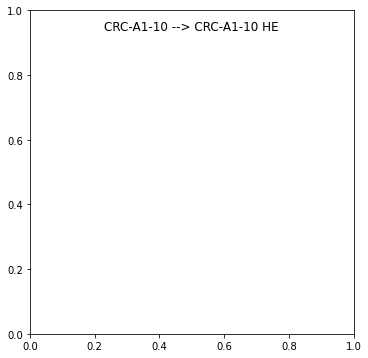

In [12]:
for idx, (path, qtree) in enumerate(results.items()):
    
    #if qtree.target_depth != 2:
    #    continue
    
    qtree.draw_feature_points(num_sub_pic=5, figsize=(12, 12))
    
    #if idx == 5:
    #    break


In [ ]:
for path, qtree in results.items():
    
    #if qtree.target_depth != 2:
    #    continue
        
    print(qtree)